# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.095266,False,-0.980755
1,-0.077687,False,-1.029517
2,-0.764927,False,-0.483828
3,-0.490037,False,-0.658410
4,-2.467743,False,-2.352241
...,...,...,...
995,-1.339400,False,0.184355
996,-0.650757,False,0.026498
997,0.169961,False,-1.095426
998,-0.734657,False,0.496390


<AxesSubplot: xlabel='v0'>

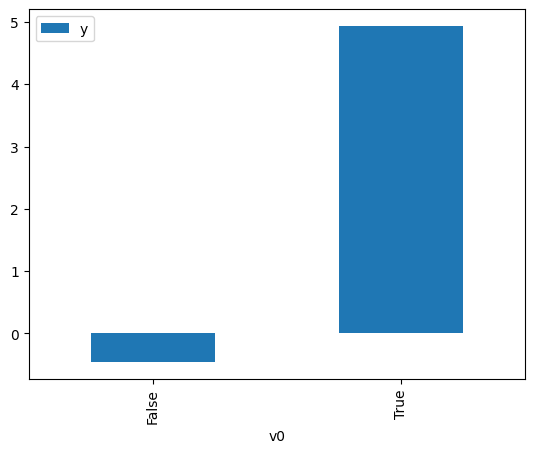

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

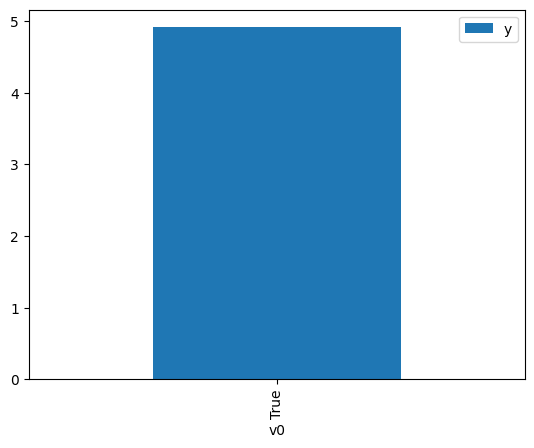

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.365949,False,0.450098,0.286874,3.485848
1,-0.323103,False,0.017540,0.695813,1.437169
2,-0.926468,False,-2.508296,0.912882,1.095431
3,1.242039,False,0.264069,0.042272,23.656361
4,-1.212809,False,-1.292107,0.955706,1.046347
...,...,...,...,...,...
995,-1.678582,False,-2.947995,0.985887,1.014315
996,-2.238726,False,-3.140978,0.996527,1.003485
997,0.650247,False,1.572697,0.164143,6.092247
998,-0.133825,False,0.372732,0.586619,1.704685


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.089949,True,4.909434,0.059429,16.826857
1,-0.210546,True,4.061782,0.367368,2.722063
2,-0.672931,True,5.034633,0.153185,6.528035
3,0.310961,True,6.259056,0.683934,1.462128
4,-1.051818,True,4.599420,0.065038,15.375524
...,...,...,...,...,...
995,-0.516684,True,4.762790,0.211531,4.727432
996,0.500000,True,6.002840,0.777082,1.286866
997,-0.274189,True,6.363094,0.330914,3.021936
998,1.431154,True,7.878213,0.973337,1.027393


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                              5991.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                        0.00
Time:                        19:54:29   Log-Likelihood:                         -1411.4
No. Observations:                1000   AIC:                                      2827.
Df Residuals:                     998   BIC:                                      2837.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8843      0.031     28.181      0.000       0.823       0.946
x2             5.0753      0.053     95.194      0.000       4.971       5.180
==============================================================================
Omnibus:                        0.887   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.642   Jarque-Bera (JB):                0.775
Skew:                           0.058   Prob(JB):                        0.679
Kurtosis:                       3.071   Cond. No.                         1.81
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""